In [1]:
import os, sys
os.environ['PYTHONHASHSEED']=str(1)
import argparse
import random

# RNN for training
import numpy as np
import pandas as pd
import math

import pickle

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [2]:
PATH_TO_REPO = '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(PATH_TO_REPO)

In [3]:
from utils.pltutils import * # import matplotlib settings
from utils.tfutils.reset_random_seed import reset_random_seed

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import to_rgb, to_rgba

# matplotlib style settings
plt.rcParams['axes.linewidth'] = 1.4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['xtick.minor.size'] = 4.0
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'

Set input arguments for training:
<br>&emsp;- PERIOD: Number of LSTM units connected in series
<br>&emsp;- UNITS: Number of hidden layers in the lSTM
<br>&emsp;- SCALER: A custom sklearn scaler can be used, if necessary, to normalize the data. If None is provided, then a scaler is initialized.

In [10]:
path_to_output = '../output'
YEAR = 2016
XTAL = 54000
PERIOD = 35
UNITS = 25
EPOCHS = 1
BATCH_SIZE = 1
SEED = 7
SCALER = 'None'
SPLIT = 0.8

During training, the dataset is shuffled in a randomized fashion. To make the results reproduciable, initialize the seed.

In [6]:
reset_random_seed(SEED)

Import data for a given crystal from the csv file. Class lstm_data_processor can be used to construct normalized arrays that can be used for training. The dataset is split into training and testing based on a given split provided.

In [7]:
X = None
Y = None

from src.python.tf.data_processor import lstm_data_processor
prsr = lstm_data_processor(XTAL, YEAR, PERIOD)
prsr.prepare_dataset_from_csv('{}/data/interim/'.format(PATH_TO_REPO), SCALER)
prsr.save_to_pickle('{}/data/processed/'.format(PATH_TO_REPO))
X = prsr.train_x
Y = prsr.train_y


trainmax = int(SPLIT*len(X))
index = np.arange(0, len(X)-1)
random.shuffle(index)


train_x = X[index][0:trainmax]
train_y = Y[index][0:trainmax]
valid_x = X[index][trainmax:]
valid_y = Y[index][trainmax:]

Using self-scaling ...


/panfs/jay/groups/2/rusack/joshib/fair_ecal_monitoring/src/python/tf/data_processor.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp['calibration+'+str(i)] = self.df['calibration'].shift(periods=-i, fill_value=0.0).to_numpy()
/panfs/jay/groups/2/rusack/joshib/fair_ecal_monitoring/src/python/tf/data_processor.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp['delta_lumi+'+str(i)] = self.df['delta_lumi'].shift(periods=-i, fill_value=0.0).to_numpy()
/panfs/jay/groups/2/rusack/joshib/fair_ecal_monitoring/src/python/

Import a model architecture and train the model.

In [11]:
from src.models.tf.lstm import lstm
model = lstm(PERIOD, UNITS)
model.model.summary()
model.model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam')

print('Model optimizer')
print(model.model.optimizer.get_config())

training_output = model.model.fit(train_x, train_y,
                            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2,
                            validation_data=(valid_x, valid_y),
                            shuffle = True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 35, 3)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 25)                2900      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 2,926
Trainable params: 2,926
Non-trainable params: 0
_________________________________________________________________
Model optimizer
{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
3244/3244 - 89s - loss: 0.0479 - val_loss: 0.0128


In [13]:
model_name = '{}/models/lstm_{}_period_{}_calib_inst_lumi_deltat_xtal_{}_epochs_{}_batch_{}_seed_{}'.format(path_to_output, UNITS, PERIOD, XTAL, EPOCHS, BATCH_SIZE, SEED)
model.model.save(model_name)

INFO:tensorflow:Assets written to: ../output/models/lstm_25_period_35_calib_inst_lumi_deltat_xtal_54000_epochs_1_batch_1_seed_7/assets


INFO:tensorflow:Assets written to: ../output/models/lstm_25_period_35_calib_inst_lumi_deltat_xtal_54000_epochs_1_batch_1_seed_7/assets


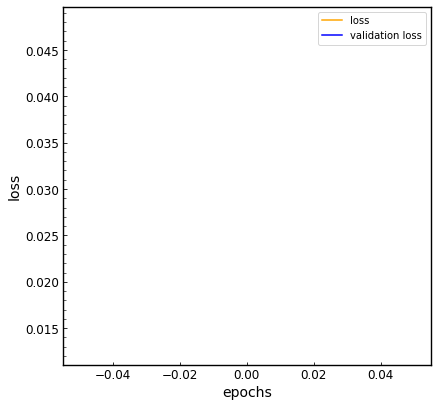

In [18]:
path_to_output = model_name
os.system('mkdir {}/plots/'.format(path_to_output))

# plot the training loss
plt.figure(figsize=(6.6,6.6))
plt.plot(training_output.epoch, training_output.history['loss'], color='orange', label='loss')
plt.plot(training_output.epoch, training_output.history['val_loss'], color='blue', label='validation loss')
plt.ylabel('loss', fontsize=14)
plt.xlabel('epochs', fontsize=14)
plt.legend()
plt.savefig('{}/plots/training_loss.png'.format(path_to_output))

In [17]:
training_output.epochs